In [1]:
import sys
import os
from glob import glob
import pickle
import os
import urllib

import numpy as np

import pandas as pd

from PIL import Image
from PIL import ImageEnhance

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

sys.path.insert(0, os.getcwd())

# import all utils
from utils import data_directory, \
                dinov3_repo_dir, \
                dinov3_vitb16_weight_raw, \
                dinov3_vith16_weight_raw
    

In [2]:
forged_folder = os.path.join(data_directory, 'train_images', 'forged')
authentic_folder = os.path.join(data_directory, 'train_images', 'authentic')
mask_folder = os.path.join(data_directory, 'train_masks')

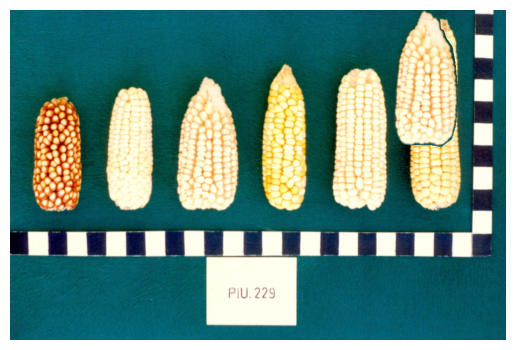

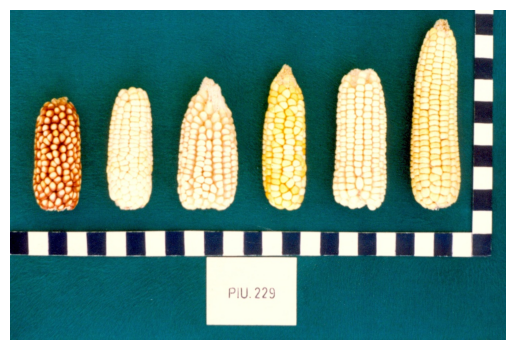

C:\Users\vishn\AppData\Local\Temp\ipykernel_11628\2327142953.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  masked_img_pil = Image.fromarray((masked_img * 255).astype(np.uint8), mode='L')


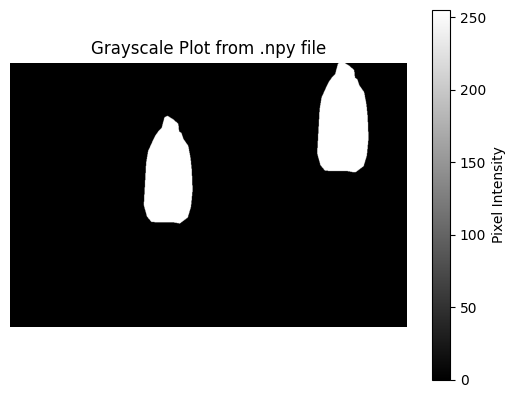

In [3]:
sample_image_path = os.path.join(forged_folder, '210.png')
forged_img = Image.open(sample_image_path).convert('RGB')
plt.imshow(forged_img)
plt.axis('off')  # Optional: hide axes
plt.show()

sample_auth_path = os.path.join(authentic_folder, '210.png')
img = Image.open(sample_auth_path).convert('RGB')
plt.imshow(img)
plt.axis('off')  # Optional: hide axes
plt.show()

sample_mask_path = os.path.join(mask_folder, '210.npy')
masked_img = np.squeeze(np.load(sample_mask_path))
masked_img_pil = Image.fromarray((masked_img * 255).astype(np.uint8), mode='L')
plt.figure()  # Create a new figure
plt.imshow(masked_img_pil, cmap='gray')
plt.title("Grayscale Plot from .npy file")
plt.axis('off')
plt.colorbar(label='Pixel Intensity')
plt.show()

In [4]:
# Available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# we take DINOv3 ViT-L
MODEL_NAME = MODEL_DINOV3_VITHP

model = torch.hub.load(
    repo_or_dir=dinov3_repo_dir,
    model=MODEL_NAME,
    source="local",
    weights=dinov3_vith16_weight_raw,
)
model.cuda()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-31): 32 x SelfAttentionBlock(
      (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (mlp): SwiGLUFFN(
        (w1): Linear(in_features=1280, out_features=5120, bias=True)
        (w2): Linear(in_features=1280, out_features=5120, bias=True)
        (w3): Linear(in_features=5120, out_features=1280, bias=True)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerNorm((

In [5]:
PATCH_SIZE = 16
DEFAULT_IMAGE_SIZE = 960 # Should be multiple of PATCH_SIZE

def resize_image_to_fit_patch(
    image: Image,
    image_size: int = DEFAULT_IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> Image:
    w, h = image.size
    h_hat = image_size
    w_hat = PATCH_SIZE * int(((w/h)*image_size)// PATCH_SIZE)
    resized_img = image.resize((w_hat, h_hat), \
                    resample=Image.Resampling.LANCZOS)
    return resized_img

In [20]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

with torch.inference_mode(): 
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for image in [forged_img]: # masked_img_pil, forged_img
            
            # processing image
            image = image.convert('RGB')
            image_resized = resize_image_to_fit_patch(image)
            image_tensor = TF.to_tensor(image_resized)
            image_normalized_tensor = TF.normalize(image_tensor, \
                                            mean=IMAGENET_MEAN, \
                                            std=IMAGENET_STD)
            image_tensorized = image_normalized_tensor.unsqueeze(0).cuda()

            # getting features
            feats = model.get_intermediate_layers(image_tensorized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            patch_features = feats[-1].squeeze().detach().cpu()
            
            # getting patches in 2D
            # Convert from [D, H, W] to [H, W, D]
            patch_features_2d = patch_features.permute(1, 2, 0)

In [21]:
image_resized.size

(1440, 960)

In [22]:
patch_features_2d.shape

torch.Size([60, 90, 1280])

Reference patch coordinates: (35, 20)
Cosine similarity map shape: torch.Size([60, 90])
Max similarity: 1.0000
Min similarity: 0.1937
Similarity threshold: 0.65
Number of patches above threshold: 1354


C:\Users\vishn\AppData\Local\Temp\ipykernel_11628\3692169231.py:56: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(high_sim_coords[1], high_sim_coords[0], c='white', s=50, marker='o',


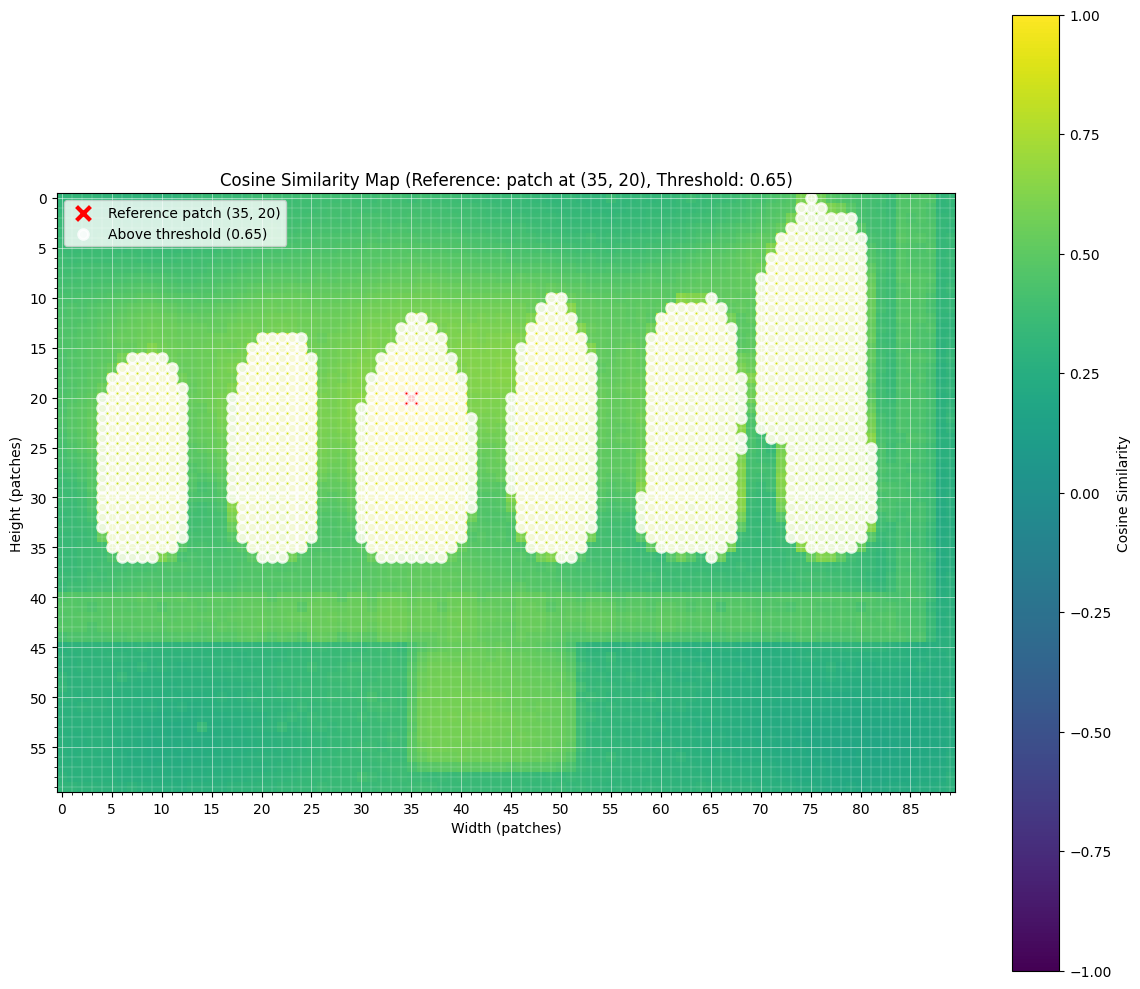

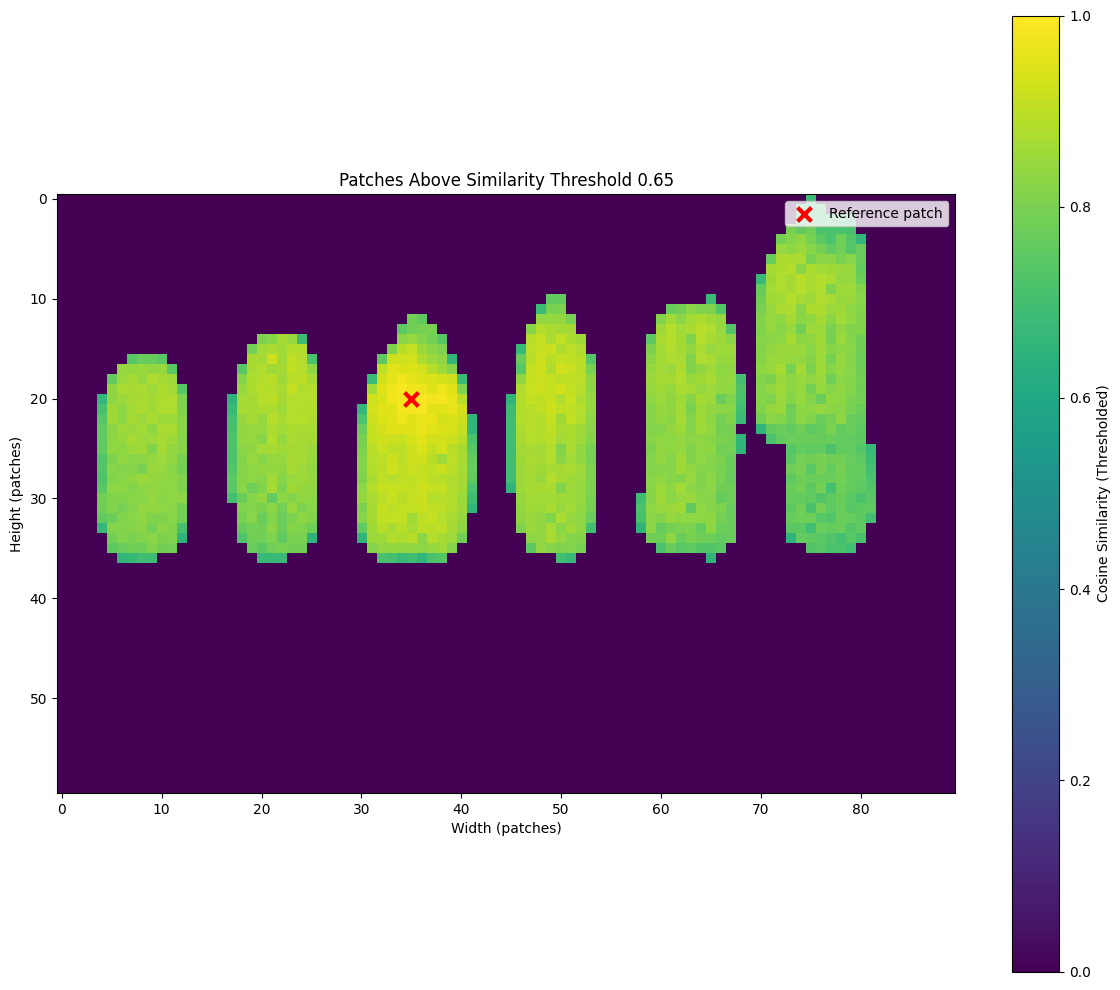

In [23]:
x_coord, y_coord = 35, 20

# Get the feature vector at the specified coordinates
reference_patch = patch_features_2d[y_coord, x_coord, :]  # Shape: [D]

# Reshape patch_features_2d to [H*W, D] for easier computation
H, W, D = patch_features_2d.shape
patch_features_flat = patch_features_2d.reshape(-1, D)  # Shape: [H*W, D]

# Calculate cosine similarity using torch.nn.functional.cosine_similarity
cosine_similarities = F.cosine_similarity(
    reference_patch.unsqueeze(0),  # Shape: [1, D]
    patch_features_flat,           # Shape: [H*W, D]
    dim=1,
)

# Reshape back to 2D spatial layout
cosine_similarity_map = cosine_similarities.reshape(H, W)  # Shape: [H, W]

# Add threshold for cosine similarity
SIMILARITY_THRESHOLD = 0.65  # Adjust this value as needed

# Create a binary mask for patches above threshold
high_similarity_mask = cosine_similarity_map > SIMILARITY_THRESHOLD

print(f"Reference patch coordinates: ({x_coord}, {y_coord})")
print(f"Cosine similarity map shape: {cosine_similarity_map.shape}")
print(f"Max similarity: {cosine_similarity_map.max():.4f}")
print(f"Min similarity: {cosine_similarity_map.min():.4f}")
print(f"Similarity threshold: {SIMILARITY_THRESHOLD}")
print(f"Number of patches above threshold: {high_similarity_mask.sum()}")

# Visualize the similarity map with granular grid
plt.figure(figsize=(12, 10))
plt.imshow(cosine_similarity_map, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title(f'Cosine Similarity Map (Reference: patch at ({x_coord}, {y_coord}), Threshold: {SIMILARITY_THRESHOLD})')
plt.xlabel('Width (patches)')
plt.ylabel('Height (patches)')

# Add granular grid
plt.grid(True, which='major', color='white', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', color='white', linewidth=0.3, alpha=0.5)

# Set major ticks every 5 patches and minor ticks every 1 patch
plt.xticks(range(0, W, 5))
plt.yticks(range(0, H, 5))
plt.gca().set_xticks(range(0, W, 1), minor=True)
plt.gca().set_yticks(range(0, H, 1), minor=True)

# Mark the reference patch
plt.scatter(x_coord, y_coord, c='red', s=100, marker='x', linewidths=3, label=f'Reference patch ({x_coord}, {y_coord})')

# Mark patches above threshold with white circles
high_sim_coords = np.where(high_similarity_mask)
plt.scatter(high_sim_coords[1], high_sim_coords[0], c='white', s=50, marker='o', 
           facecolors='none', edgecolors='white', linewidths=2, alpha=0.8, 
           label=f'Above threshold ({SIMILARITY_THRESHOLD})')

plt.legend()
plt.tight_layout()
plt.show()

# Optional: Show only patches above threshold
plt.figure(figsize=(12, 10))
thresholded_map = np.where(high_similarity_mask, cosine_similarity_map, 0)
plt.imshow(thresholded_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity (Thresholded)')
plt.title(f'Patches Above Similarity Threshold {SIMILARITY_THRESHOLD}')
plt.xlabel('Width (patches)')
plt.ylabel('Height (patches)')
plt.scatter(x_coord, y_coord, c='red', s=100, marker='x', linewidths=3, label=f'Reference patch')
plt.legend()
plt.tight_layout()
plt.show()